In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!nvidia-smi

Thu Jan  6 16:50:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as PP , MobileNetV2

import os
import shutil
import seaborn as sn

%matplotlib inline

In [18]:
data_path = '/content/drive/MyDrive/Mask_detection_dataset'

classes = ['with_mask/', 'without_mask/']

sample_images = []
for c in classes:
  for n,i in enumerate(os.listdir(os.path.join(data_path,c.replace('/','')))):
    if n==50: break
    sample_images.append(cv2.imread(os.path.join(data_path,c+i)))

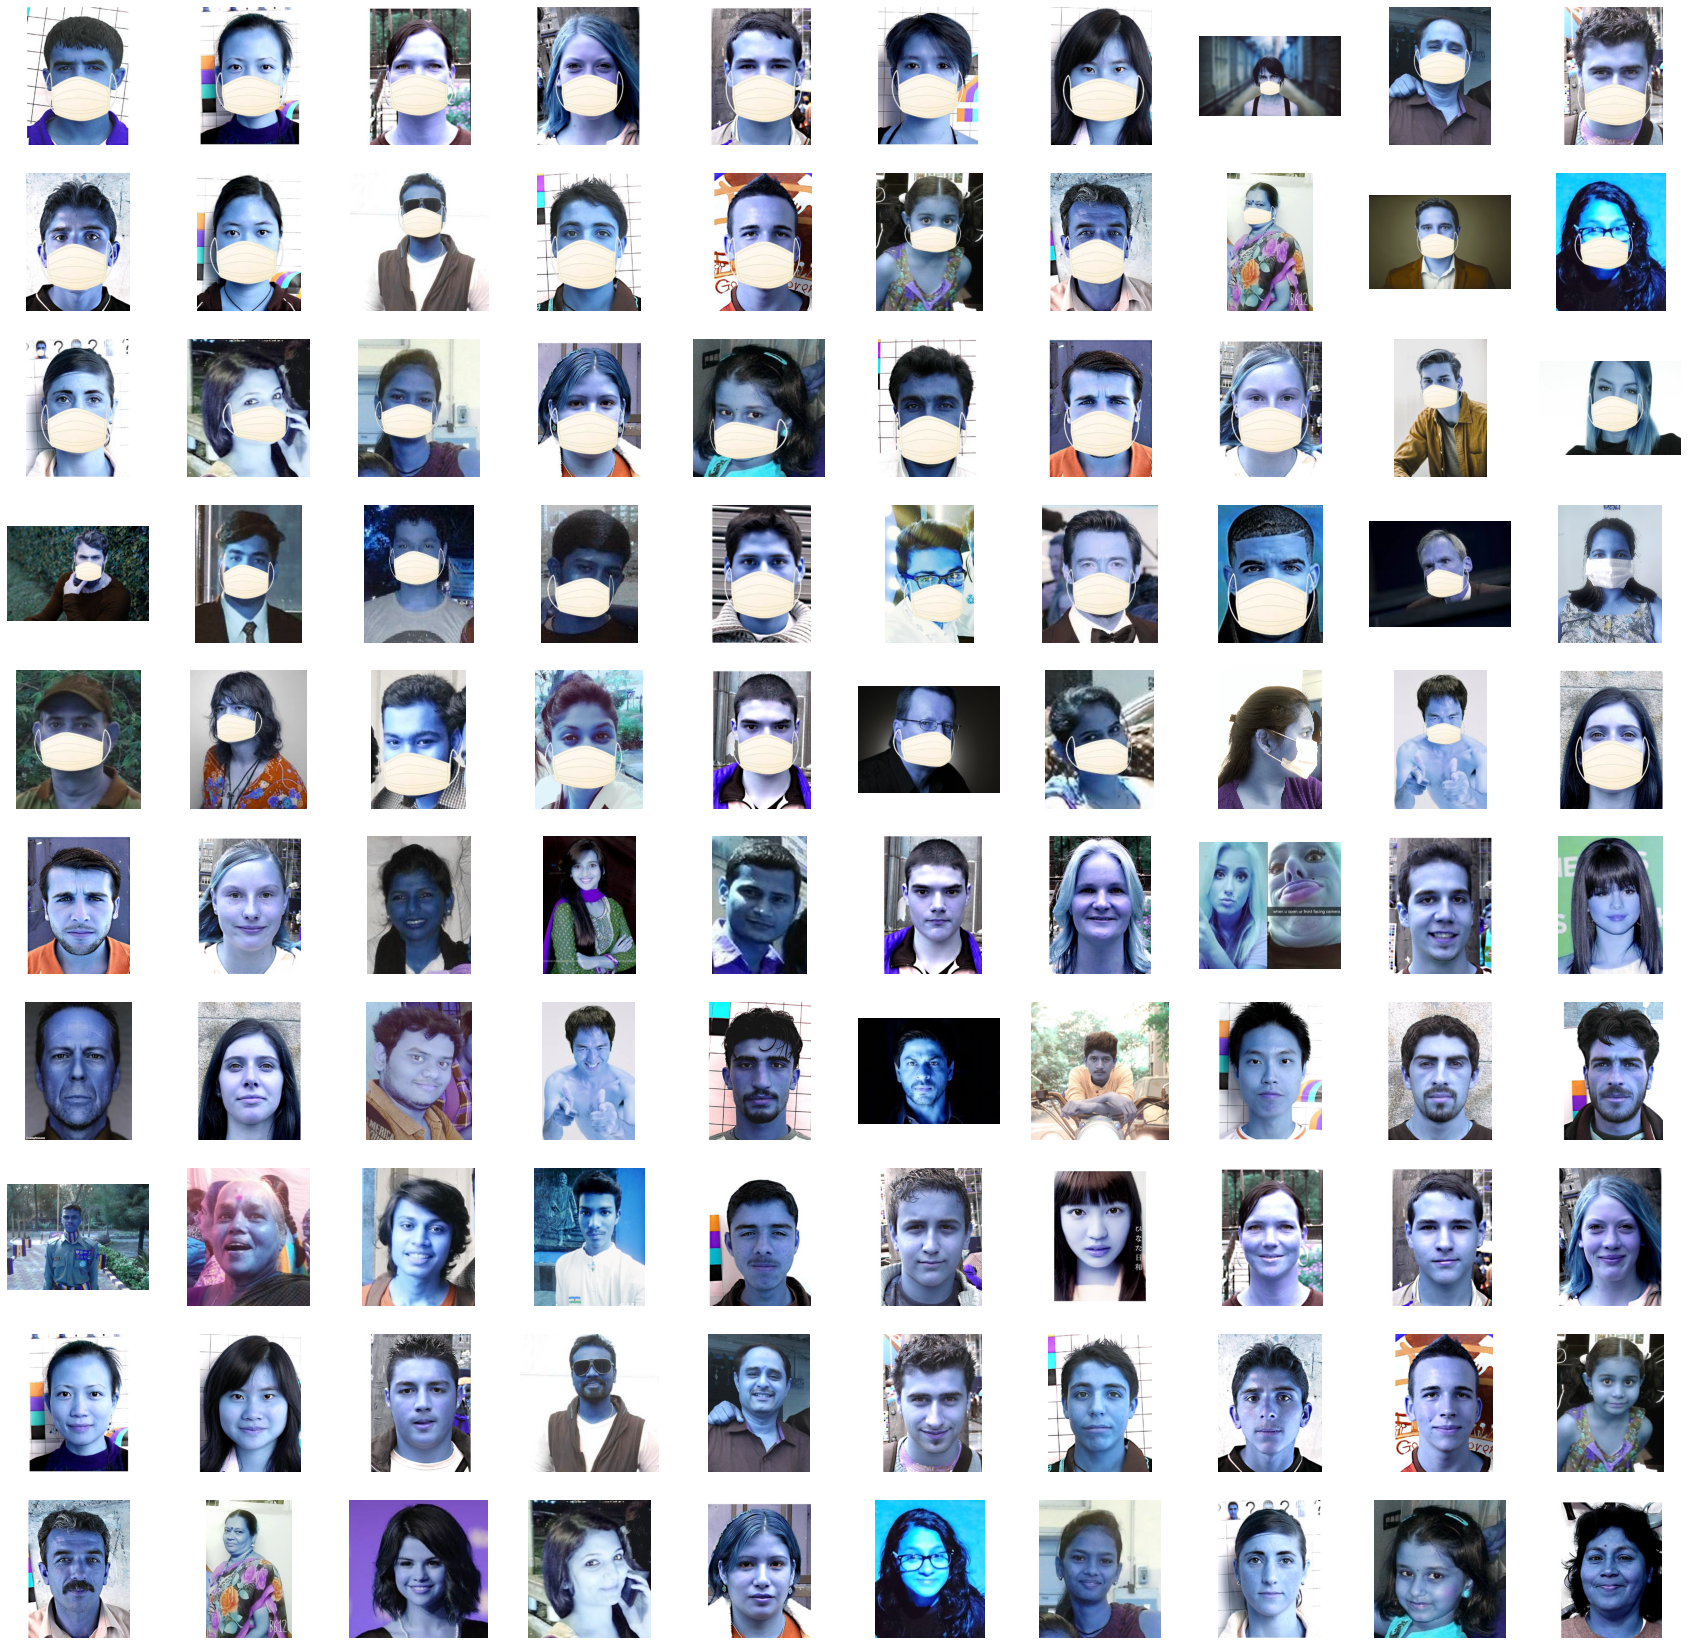

In [19]:
fig = plt.figure(figsize = (30,30))
row,col = 10,10
for i in range(row*col):
  fig.add_subplot(row,col,i+1)
  plt.imshow(sample_images[i])
  plt.axis('off')

In [20]:
for i in (sample_images[:5]):
  print(i.shape)

(433, 320, 3)
(428, 320, 3)
(433, 327, 3)
(428, 320, 3)
(428, 320, 3)


In [21]:
image_gen = IDG(vertical_flip=True,horizontal_flip=True,shear_range=0.2,zoom_range=0.3,preprocessing_function=PP,validation_split=0.2)
test_data_gen = IDG(preprocessing_function=PP)

**Following operation not allowed as data is a shared file**


**Due to lack of permissions, test data can only be generated manually.**

Hence, we'll make inferences later when the model is called during real time detection.

In [26]:
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False , classes=2)

9420800/9406464 [==============================] - 0s 0us/step


In [27]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

**Will fine tune the base model and later layers after the later layers have been trained with image net weights**

In [28]:
for i in base_model.layers:
  i.trainable=False

In [29]:
conv1 = Conv2D(1024,(3,3), activation = 'relu')(base_model.output)
batch1 = BatchNormalization()(conv1)
pool1 = MaxPool2D(2)(batch1)



flat = Flatten()(pool1)
fc1 =  BatchNormalization()(Dense(1024,activation='relu')(flat))
drop1 = Dropout(0.3)(fc1)
out = Dense(1,activation = 'sigmoid')(drop1)

model = Model(inputs = base_model.input, outputs = out)

In [30]:
model.compile(loss='binary_crossentropy',optimizer = Adam(learning_rate =0.001),metrics = ['accuracy'])

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [32]:
train_gen = image_gen.flow_from_directory(data_path,target_size=(224,224),batch_size= 64,class_mode ='binary',shuffle = True,subset='training')
valid_gen = image_gen.flow_from_directory(data_path,target_size=(224,224),batch_size= 64,class_mode ='binary',shuffle = True,subset='validation')

Found 1101 images belonging to 2 classes.
Found 275 images belonging to 2 classes.


In [33]:
fpath="/content/mask_model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=fpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks = [checkpoint]

In [34]:
hist = model.fit(train_gen,steps_per_epoch=1101//64, epochs = 8, validation_data= valid_gen,validation_steps=275//64,use_multiprocessing=True,workers=4,callbacks=callbacks)

Epoch 1/8
17/17 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9402
Epoch 00001: val_loss improved from inf to 1.21906, saving model to /content/mask_model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


17/17 [==============================] - 32s 866ms/step - loss: 0.1716 - accuracy: 0.9402 - val_loss: 1.2191 - val_accuracy: 0.9180
Epoch 2/8
17/17 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9836
Epoch 00002: val_loss improved from 1.21906 to 0.13787, saving model to /content/mask_model.h5
17/17 [==============================] - 20s 1s/step - loss: 0.0666 - accuracy: 0.9836 - val_loss: 0.1379 - val_accuracy: 0.9844
Epoch 3/8
17/17 [==============================] - ETA: 0s - loss: 0.0364 - accuracy: 0.9894
Epoch 00003: val_loss did not improve from 0.13787
17/17 [==============================] - 20s 1s/step - loss: 0.0364 - accuracy: 0.9894 - val_loss: 0.2065 - val_accuracy: 0.9844
Epoch 4/8
17/17 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9926
Epoch 00004: val_loss improved from 0.13787 to 0.05314, saving model to /content/mask_model.h5
17/17 [==============================] - 21s 1s/step - loss: 0.0204 - accuracy: 0.9926 - v

**Fine tuning the entire model**

In [35]:
for i in model.layers:
  i.trainable = True

In [36]:
model.compile(loss='binary_crossentropy',optimizer = Adam(learning_rate =1e-6),metrics = ['accuracy']) #low learning rate for fine tuning

In [37]:
hist = model.hist = model.fit(train_gen,steps_per_epoch=1101//64, epochs = 8, validation_data= valid_gen,validation_steps=275//64,use_multiprocessing=True,workers=3,callbacks=callbacks)

Epoch 1/8
17/17 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.9209
Epoch 00001: val_loss did not improve from 0.03317
17/17 [==============================] - 32s 1s/step - loss: 0.3296 - accuracy: 0.9209 - val_loss: 0.1155 - val_accuracy: 0.9844
Epoch 2/8
17/17 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9431
Epoch 00002: val_loss did not improve from 0.03317
17/17 [==============================] - 23s 1s/step - loss: 0.2455 - accuracy: 0.9431 - val_loss: 0.1324 - val_accuracy: 0.9727
Epoch 3/8
17/17 [==============================] - ETA: 0s - loss: 0.2396 - accuracy: 0.9450
Epoch 00003: val_loss improved from 0.03317 to 0.00725, saving model to /content/mask_model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


17/17 [==============================] - 23s 1s/step - loss: 0.2396 - accuracy: 0.9450 - val_loss: 0.0073 - val_accuracy: 0.9961
Epoch 4/8
17/17 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.9441
Epoch 00004: val_loss did not improve from 0.00725
17/17 [==============================] - 23s 1s/step - loss: 0.1929 - accuracy: 0.9441 - val_loss: 0.0956 - val_accuracy: 0.9883
Epoch 5/8
17/17 [==============================] - ETA: 0s - loss: 0.2292 - accuracy: 0.9421
Epoch 00005: val_loss did not improve from 0.00725
17/17 [==============================] - 24s 1s/step - loss: 0.2292 - accuracy: 0.9421 - val_loss: 0.1427 - val_accuracy: 0.9844
Epoch 6/8
17/17 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9508
Epoch 00006: val_loss did not improve from 0.00725
17/17 [==============================] - 23s 1s/step - loss: 0.2042 - accuracy: 0.9508 - val_loss: 0.0532 - val_accuracy: 0.9883
Epoch 7/8
17/17 [==============================] - E

In [38]:
json_model = model.to_json()
with open('/content/mask_model.json','w') as f:
  f.write(json_model)
f.close()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
